In [130]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

# Parameters
lambda_ = 0.05  
beta = 1     
k = 1        
delta_t = 1
M=40
m=4
num_trajectories = 300
s_0_values = np.linspace(-np.pi, np.pi, num_trajectories)

# Linear deterministic dynamics (discrete-time)
def s(j,delta_t,s_0):
    return s_0*np.exp(lambda_ * j * delta_t)
    
# Reward function
def reward_function(s):
    reward = beta * np.cos(k * s) ** 3 - lambda_ * s * (-3 * k * np.cos(k * s)**3 * np.sin(k * s))
    return reward

# Define periodic bases
def bases(s):
    bases=[1/np.sqrt(2*np.pi)]
    for m in range(1,M+1):
        bases.append(np.cos(m*s)/np.sqrt(np.pi))
        bases.append(np.sin(m*s)/np.sqrt(np.pi))
    return np.array(bases).reshape(-1,1)   #return column vector

def gradient_bases(s):
    gradient_bases=[0]
    for m in range(1,M+1):
        gradient_bases.append(-m*np.sin(m*s)/np.sqrt(np.pi))
        gradient_bases.append(m*np.cos(m*s)/np.sqrt(np.pi))
    return np.array(gradient_bases).reshape(-1,1)  

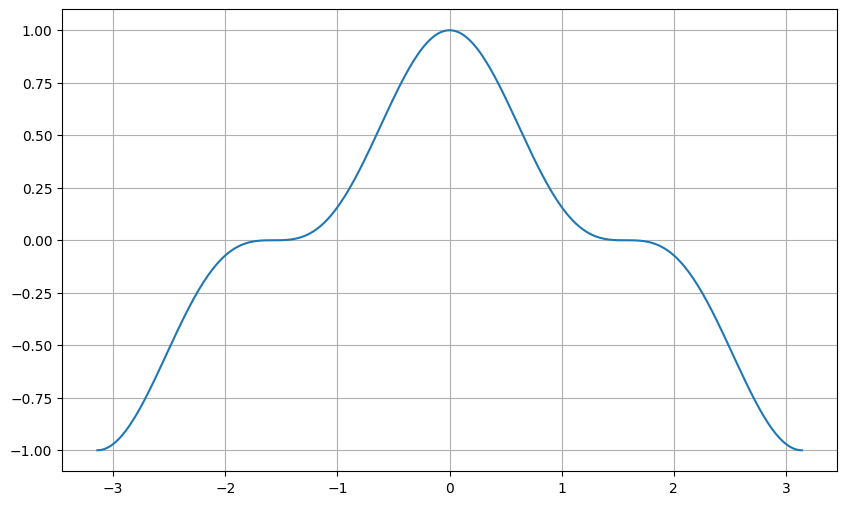

In [131]:
# True Value function

True_values = np.cos(k*s_0_values)**3

plt.figure(figsize=(10, 6))
plt.plot(s_0_values, True_values)
plt.grid()
plt.show()


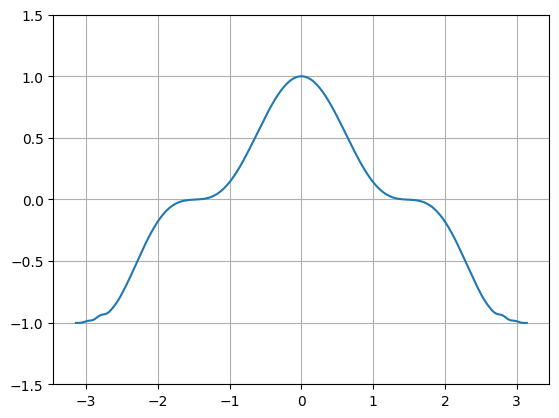

In [132]:
# Algorithm 1 to 2-nd order PhiBE
def mu_2(j,s_0):
    return 2*(s(j + 1,delta_t,s_0) - s(j,delta_t,s_0))/delta_t - (s(j + 2,delta_t,s_0) - s(j,delta_t,s_0)) / (2 *delta_t)

A = np.zeros((2 * M + 1, 2 * M + 1))  # Matrix A
b = np.zeros((2 * M + 1, 1))  # Vector b



for s_0 in s_0_values:
    for j in range(0, m - 1):
        Phi = bases(s(j,delta_t,s_0))
        A += Phi @ (beta * Phi - mu_2(j,s_0) * gradient_bases(s(j,delta_t,s_0))).T
        r = reward_function(s(j,delta_t,s_0))
        b += r * Phi


theta = np.linalg.solve(A, b)


V_Galerkin_2nd_values = []
for s_0 in s_0_values:
    V_Galerkin = theta.T @ bases(s_0)
    V_Galerkin_2nd_values.append(V_Galerkin.item())

plt.plot(s_0_values,V_Galerkin_2nd_values)
plt.ylim(-1.5, 1.5)
plt.grid()
plt.show()

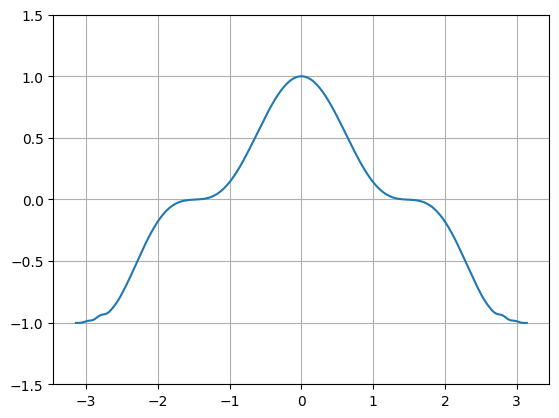

In [133]:
#solution to 2-nd order PhiBE
def mu_2_true(j,s_0):
    return 2*((np.exp(lambda_*delta_t)-1)*s(j,delta_t,s_0))/delta_t - ((np.exp(2*lambda_*delta_t)-1)*s(j,delta_t,s_0)) / (2 *delta_t)

A2 = np.zeros((2 * M + 1, 2 * M + 1))  # Matrix A
b2 = np.zeros((2 * M + 1, 1))  # Vector b




for s_0 in s_0_values:
    for j in range(0, m-1):
        Phi = bases(s(j,delta_t,s_0))
        A2 += np.outer(Phi, beta * Phi.T - mu_2_true(j,s_0) * gradient_bases(s(j,delta_t,s_0)).T)
        r = reward_function(s(j,delta_t,s_0))
        b2 += r * Phi

V_PhiBE_2nd_values = []
theta2 = np.linalg.solve(A2, b2)   
for s_0 in s_0_values:
    a = theta2.T @ bases(s_0)
    V_PhiBE_2nd_values.append(a.item())

plt.plot(s_0_values,V_PhiBE_2nd_values)
plt.ylim(-1.5, 1.5)
plt.grid()
plt.show()

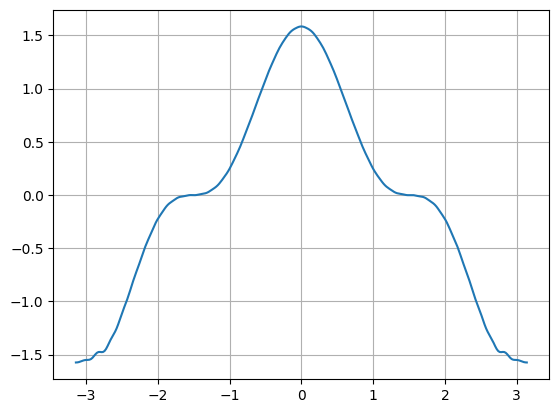

In [134]:
#LSTD to BE
# Initialize A and b
A3 = np.zeros((2 * M + 1, 2 * M + 1))  # Matrix A
b3 = np.zeros((2 * M + 1, 1))  # Vector b



# Collect data to compute A and b
for s_0 in s_0_values:
    for j in range(0, m - 1):
        Phi_j = bases(s(j, delta_t, s_0))
        Phi_j_plus1 = bases(s(j + 1, delta_t, s_0))
        A3 += Phi_j @ (Phi_j - np.exp(-beta * delta_t) * Phi_j_plus1).T
        r = reward_function(s(j, delta_t, s_0))*delta_t
        b3 += r * Phi_j

# Solve for theta
theta3 = np.linalg.solve(A3, b3)

# Compute V_LSTD(s) for all s_0
LSTD_values = []
for s_0 in s_0_values:
    V_LSTD = theta3.T @ bases(s_0)
    LSTD_values.append(V_LSTD.item())

plt.plot(s_0_values,LSTD_values)
#plt.ylim(-2, 2)
plt.grid()
plt.show()

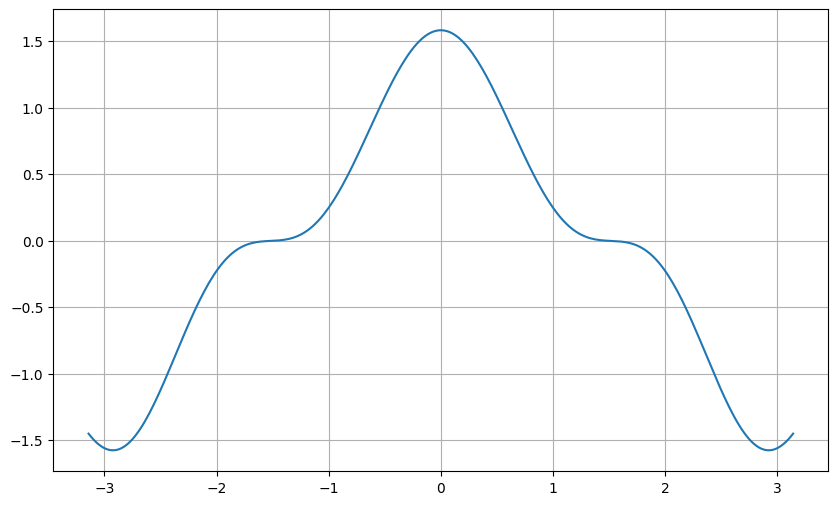

In [135]:
#solution to BE
def Sol_BE(s_0):
    V = 0  
    for j in range(0,10):
        V += np.exp(-beta*j*delta_t)*reward_function(s(j,delta_t,s_0)) * delta_t
    return V


BE_values = np.array([Sol_BE(s) for s in s_0_values])

plt.figure(figsize=(10, 6))
plt.plot(s_0_values,BE_values)
plt.grid()
plt.show()


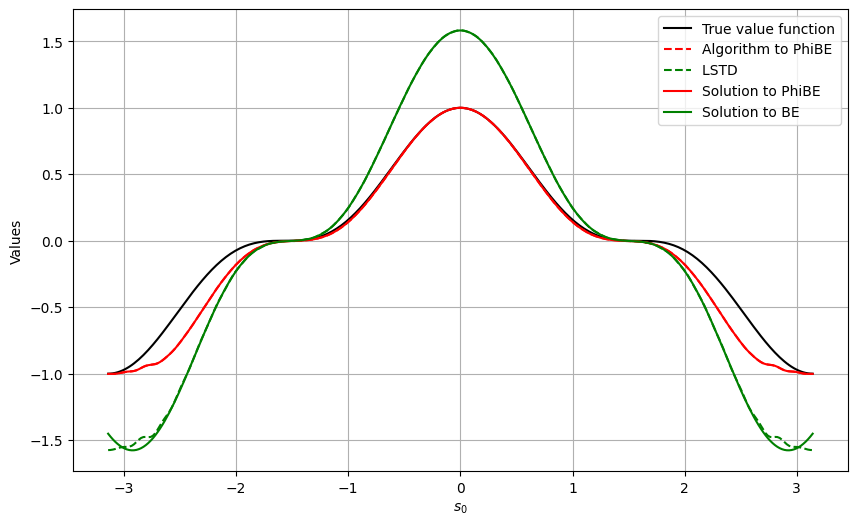

In [136]:
#plot together
plt.figure(figsize=(10, 6))

plt.plot(s_0_values, True_values, 'k-', label='True value function')  
plt.plot(s_0_values, V_Galerkin_2nd_values, 'r--', label='Algorithm to PhiBE')  
plt.plot(s_0_values, LSTD_values, 'g--', label='LSTD ')  #
plt.plot(s_0_values, V_PhiBE_2nd_values, 'r-', label='Solution to PhiBE')  
plt.plot(s_0_values, BE_values, 'g-', label='Solution to BE')  


plt.xlabel('$s_0$')
plt.ylabel('Values')


plt.legend()
plt.grid(True)
plt.show()